## Imports

In [1]:
%load_ext autoreload
%autoreload 2
import os
import re
import json
import sys
from tqdm import tqdm
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

import pytrec_eval
import numpy as np
import pandas as pd
from elasticsearch import Elasticsearch

sys.path.append('../../')
import globals
from src.elastic_search_utils import elastic_utils

Home path : /opt/bioasq/col-un-bioasq11
Eval path : /opt/bioasq/Evaluation-Measures


## Testing fast usage wrappers for elastic queries

In [2]:
elastic_utils.ask_single_doc_id('d33811342')

/home/andresr/.local/lib/python3.9/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


{'d33811342': {'score': 1,
  'title': "Testing children with COVID-19 symptoms: what are parents' intentions?",
  'abstract': '',
  'mesh_terms': ['D000293:Adolescent',
   'D001315:Australia',
   'D000086382:COVID-19',
   'D000086742:COVID-19 Testing',
   'D002648:Child',
   'D002675:Child, Preschool',
   'D006801:Humans',
   'D033182:Intention',
   'D010290:Parents',
   'D000086402:SARS-CoV-2']}}

In [3]:
elastic_utils.get_single_question_metrics('what are the symptoms of Covid?')

{'documents': {'d33811342': {'score': 0.22849094,
   'title': "Testing children with COVID-19 symptoms: what are parents' intentions?",
   'abstract': '',
   'mesh_terms': ['D000293:Adolescent',
    'D001315:Australia',
    'D000086382:COVID-19',
    'D000086742:COVID-19 Testing',
    'D002648:Child',
    'D002675:Child, Preschool',
    'D006801:Humans',
    'D033182:Intention',
    'D010290:Parents',
    'D000086402:SARS-CoV-2']},
  'd34478600': {'score': 0.22427094,
   'title': "What are the factors that affect post COVID 1st month's continuing symptoms?",
   'abstract': 'AIM\nThe aim of our research was to investigate retrospectively the relationship between the symptoms and general characteristics, initial laboratory values and treatments in patients who had COVID-19 and who applied to the chest diseases outpatient clinic for control after 1\xa0month.\n\n\nMETHOD\nThree hundred fifteen patients who were diagnosed with COVID-19 and applied to the chest diseases outpatient clinic bet

## Params

In [5]:
ELASTIC_SERVER = "http://localhost:9200"
QUESTIONS_PATH = "../../data/raw/training11b.json"
N_ANSWERS = 100
SEARCH_FIELDS = ['title', 'abstract', 'mesh_terms']
SEARCH_INDEX = 'pubmed2023-old'

SAVING_PATH_TRAINING = '/opt/bioasq/tmp/training_docs_11b.json'
SAVING_PATH_ASKED = '/opt/bioasq/tmp/queried_docs_11b.json'

## Constants

In [6]:
es = Elasticsearch(ELASTIC_SERVER)

In [7]:
questions = elastic_utils.load_questions(QUESTIONS_PATH)

In [8]:
count_docs = [len(question['documents']) for question in questions]

In [9]:
pd.Series(count_docs).describe()

count    4719.000000
mean        9.029032
std         9.662633
min         1.000000
25%         2.000000
50%         6.000000
75%        13.000000
max       157.000000
dtype: float64

In [10]:
pd.Series(count_docs).quantile(0.90)

21.0

/tmp/ipykernel_137555/3101482199.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(count_docs)


<AxesSubplot: ylabel='Density'>

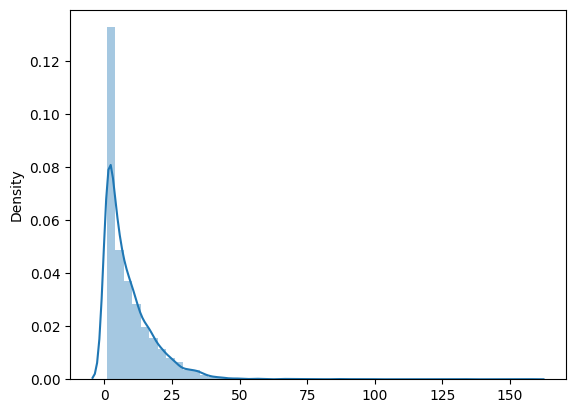

In [11]:
sns.distplot(count_docs)

## Making gold standard
### Making base gold standard dict

In [13]:
gold_standard = elastic_utils.make_gold_standard(questions)

Making base gold standard: 100%|████████████████████████████████████████████████████████████████████████████████████████| 4719/4719 [00:00<00:00, 116568.14it/s]


## Extracting abstracts and titles from question documents 
### Unique documents

In [14]:
unique_documents = elastic_utils.extract_all_document_ids(
    questions
)
len(unique_documents)

Document id extraction: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 4719/4719 [00:00<00:00, 166702.49it/s]


42608

### Querying documents 

In [15]:
doc_ans = elastic_utils.ask_all_doc_id(unique_documents, SEARCH_FIELDS, es, SEARCH_INDEX)

Querying training document ids:   0%|                                                                                                 | 0/42608 [00:00<?, ?it/s]/home/andresr/.local/lib/python3.9/site-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
Querying training document ids: 100%|████████████████████████████████████████████████████████████████████████████████████| 42608/42608 [01:39<00:00, 426.92it/s]


### Changing gold standard to have document info

In [16]:
elastic_utils.add_doc_info_to_gold_standard(gold_standard, doc_ans)

Adding doc info to gold standard: 100%|█████████████████████████████████████████████████████████████████████████████████| 4719/4719 [00:00<00:00, 209435.60it/s]


## Making answers for training

### Single answer example

In [17]:
sample_answers = elastic_utils.ask_single_question(
    question=questions[0],
    fields=SEARCH_FIELDS,
    size=N_ANSWERS,
    es_client=es,
    index=SEARCH_INDEX
)

In [24]:
print(elastic_utils.extract_title_abstract_mesh_terms(sample_answers))

{'d15858239': {'score': 0.34125973000000004, 'title': '[The role of ret gene in the pathogenesis of Hirschsprung disease].', 'abstract': 'Hirschsprung disease is a congenital disorder with the incidence of 1 per 5000 live births, characterized by the absence of intestinal ganglion cells. In the etiology of Hirschsprung disease various genes play a role; these are: RET, EDNRB, GDNF, EDN3 and SOX10, NTN3, ECE1, Mutations in these genes may result in dominant, recessive or multifactorial patterns of inheritance. Diverse models of inheritance, co-existence of numerous genetic disorders and detection of numerous chromosomal aberrations together with involvement of various genes confirm the genetic heterogeneity of Hirschsprung disease. Hirschsprung disease might well serve as a model for many complex disorders in which the search for responsible genes has only just been initiated. It seems that the most important role in its genetic etiology plays the RET gene, which is involved in the etio

In [18]:
sample_answers.keys()

dict_keys(['took', 'timed_out', '_shards', 'hits'])

In [19]:
pprint(sample_answers['hits']['hits'][0])

{'_id': '15858239',
 '_ignored': ['abstract.keyword'],
 '_index': 'pubmed2023-old',
 '_score': 34.125973,
 '_source': {'abstract': 'Hirschsprung disease is a congenital disorder with '
                         'the incidence of 1 per 5000 live births, '
                         'characterized by the absence of intestinal ganglion '
                         'cells. In the etiology of Hirschsprung disease '
                         'various genes play a role; these are: RET, EDNRB, '
                         'GDNF, EDN3 and SOX10, NTN3, ECE1, Mutations in these '
                         'genes may result in dominant, recessive or '
                         'multifactorial patterns of inheritance. Diverse '
                         'models of inheritance, co-existence of numerous '
                         'genetic disorders and detection of numerous '
                         'chromosomal aberrations together with involvement of '
                         'various genes confirm the gene

In [20]:
single_metrics = elastic_utils.answers_to_id_metric(
    sample_answers
)

In [21]:
single_metrics

{'d15858239': 0.34125973000000004,
 'd11106284': 0.3304699,
 'd15829955': 0.32477596,
 'd3578280': 0.32177456,
 'd10893883': 0.31766972,
 'd23283078': 0.31185501,
 'd6650562': 0.31127289999999996,
 'd17965226': 0.30465504,
 'd16965318': 0.29992252,
 'd30954460': 0.29147903,
 'd23465774': 0.28968151,
 'd28532160': 0.2871134,
 'd22891492': 0.28372358,
 'd22475248': 0.28174885,
 'd9600737': 0.27842356,
 'd11484199': 0.27693056,
 'd12239580': 0.27302563,
 'd11694544': 0.27269922,
 'd25323865': 0.27267227,
 'd10370906': 0.27205265,
 'd27639057': 0.27019136,
 'd8877363': 0.27014254,
 'd16986122': 0.26979127999999997,
 'd2213441': 0.26783308,
 'd9465697': 0.26710867,
 'd27370713': 0.26708973,
 'd9174404': 0.26617102,
 'd655638': 0.26497941999999997,
 'd30924549': 0.2646232,
 'd2335126': 0.26378609999999997,
 'd33768880': 0.26362247,
 'd29677472': 0.26322865,
 'd18472352': 0.26273043,
 'd35080777': 0.26265852,
 'd7634536': 0.26157421,
 'd23842858': 0.26141833999999997,
 'd20813343': 0.26130392

### Multiple question answering

In [22]:
%%time
multiple_ans = elastic_utils.ask_several_questions(
    questions=questions,
    fields=SEARCH_FIELDS,
    size=N_ANSWERS,
    es_client=es,
    index=SEARCH_INDEX
)

Extracting docs from elastic search: 100%|██████████████████████████████████████████████████████████████████████████████████| 4719/4719 [41:14<00:00,  1.91it/s]

CPU times: user 26.6 s, sys: 4.59 s, total: 31.2 s
Wall time: 41min 14s


## Saving dicts

In [21]:
elastic_utils.save_json(gold_standard, SAVING_PATH_TRAINING)
elastic_utils.save_json(multiple_ans, SAVING_PATH_ASKED)

## Compare read with saved json

In [22]:
gold_standard_read = elastic_utils.load_json(SAVING_PATH_TRAINING)

In [23]:
multiple_ans_read = elastic_utils.load_json(SAVING_PATH_ASKED)

In [24]:
lens_docs = []
weird_questions = []
for result in multiple_ans:
    result_id = list(result.keys())[0]
    len_docs = len(result[result_id]['documents'].keys())
    if len_docs < N_ANSWERS:
        print(result_id, len_docs)
        weird_questions.append(result_id)
        lens_docs.append(len_docs)

In [25]:
cleaned_weird_questions = [
    weird_question.replace('q','') for weird_question in weird_questions
]

weird_og_questions = [
    question for question in questions
    if question['id'] in cleaned_weird_questions
]
len(weird_og_questions), len(cleaned_weird_questions)

(0, 0)

In [26]:
pd.value_counts(lens_docs)

Series([], dtype: int64)

In [27]:
weird_ans = elastic_utils.ask_several_questions(
    questions=weird_og_questions,
    fields=SEARCH_FIELDS,
    size=N_ANSWERS,
    es_client=es,
    index=SEARCH_INDEX
)

Extracting docs from elastic search: 0it [00:00, ?it/s]


In [28]:
lens_docs = []
weird_questions = []
for result in weird_ans:
    result_id = list(result.keys())[0]
    len_docs = len(result[result_id]['documents'].keys())
    if len_docs < N_ANSWERS:
        print(result_id, len_docs)
        weird_questions.append(result_id)
        lens_docs.append(len_docs)
len(lens_docs)

0

In [29]:
raw_single_answers = elastic_utils.ask_single_question(
    weird_og_questions[0],
    fields=SEARCH_FIELDS,
    size=N_ANSWERS,
    es_client=es,
    index=SEARCH_INDEX
)

IndexError: list index out of range